<a href="https://colab.research.google.com/github/Krixna-Kant/IGRS_Hackofiesta/blob/main/IGRS_Model(Final).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install pandas folium opencage google-generativeai tabulate

In [2]:
import pandas as pd
import folium
import re
from opencage.geocoder import OpenCageGeocode
from google.generativeai import configure, GenerativeModel
from IPython.display import display
from tabulate import tabulate

API Keys

In [3]:
from google.colab import userdata
OPENCAGE_API_KEY = userdata.get('OPENCAGE_API_KEY')
GEMINI_API_KEY = userdata.get('GEMINI_API_KEY')

Intializing

In [4]:
geocoder = OpenCageGeocode(OPENCAGE_API_KEY)
configure(api_key=GEMINI_API_KEY)
gemini = GenerativeModel("gemini-pro")

Extracting City and State

In [5]:
def extract_location(problem_text):
    location_patterns = [r'\b(?:in|at|near|around)\s+([A-Z][a-z]+(?:\s[A-Z][a-z]+)*)\b']
    for pattern in location_patterns:
        match = re.search(pattern, problem_text)
        if match:
            return match.group(1)
    return "Unknown Location"

Location Part

In [6]:
def get_location(address):
    try:
        result = geocoder.geocode(address)
        if result:
            return {"latitude": result[0]['geometry']['lat'], "longitude": result[0]['geometry']['lng'], "address": result[0]['formatted']}
        else:
            return {"latitude": None, "longitude": None, "address": "Unknown"}
    except:
        return {"latitude": None, "longitude": None, "address": "Unknown"}

AI for giving Solutions

In [7]:
def suggest_solution(problem):
    prompt = f"""
    Generate a **structured, step-by-step solution** for the following grievance:
    **Problem:** {problem}

    **Output Format Example:**
    - **Issue Analysis:** [Detailed cause of the problem]
    - **Immediate Action:** [Quick fixes citizens can take]
    - **Long-Term Plan:** [Policy or infrastructure changes needed]
    - **Responsible Authorities:** [Which gov. bodies should handle this]
    """
    try:
        response = gemini.generate_content(prompt)
        return response.text.strip() if response else "No suggestion available"
    except:
        return "No suggestion available"

Categorize Grievance

In [8]:
def categorize_problem(problem):
    problem_lower = problem.lower()
    if "road" in problem_lower or "traffic" in problem_lower:
        return "Infrastructure"
    elif "water" in problem_lower or "electricity" in problem_lower:
        return "Utilities"
    elif "garbage" in problem_lower or "sanitation" in problem_lower:
        return "Sanitation"
    elif any(word in problem_lower for word in ["hospital", "doctor", "medicine", "ambulance", "emergency", "health"]):
        return "Medical"
    else:
        return "Other"

Assigning Priority

In [9]:
def assign_priority(problem):
    problem_lower = problem.lower()
    if any(word in problem_lower for word in ["hospital", "doctor", "medicine", "ambulance", "emergency", "health"]):
        return "High"
    elif any(word in problem_lower for word in ["pothole", "flood", "accident", "fire", "collapse", "power outage"]):
        return "High"
    elif any(word in problem_lower for word in ["supply issue", "power cut", "shortage", "repair needed"]):
        return "Medium"
    else:
        return "Low"

For Single Grievance

In [10]:
def process_single_grievance(problem):
    region = extract_location(problem)
    category = categorize_problem(problem)
    priority = assign_priority(problem)
    location = get_location(region)
    latitude = location["latitude"]
    longitude = location["longitude"]
    solution = suggest_solution(problem)

    return pd.DataFrame([{"Problem": problem, "Category": category, "Priority": priority, "Region": region, "Latitude": latitude, "Longitude": longitude, "Solution": solution}])

For Processing CSV File

In [11]:
def process_csv_file(csv_file):
    df = pd.read_csv(csv_file)
    processed_grievances = []

    for _, row in df.iterrows():
        original_data = row.to_dict()
        problem = original_data.get("Problem", "")
        processed_df = process_single_grievance(problem)
        combined_data = {**original_data, **processed_df.iloc[0].to_dict()}
        processed_grievances.append(pd.DataFrame([combined_data]))

    df_processed = pd.concat(processed_grievances, ignore_index=True)
    return df_processed.sort_values(
        by="Priority",
        ascending=False,
        key=lambda x: x.map({"Low": 1, "Medium": 2, "High": 3})
    )

Display Result Function

In [12]:
def display_table(df):
    print("**Processed Grievances:**\n")
    print(tabulate(df, headers="keys", tablefmt="fancy_grid"))

Saving Processed Grievances to CSV

In [13]:
def save_to_csv(df):
    import os  # Add this at the top to use path functions

    output_file = "Processed_Grievances.csv"
    required_columns = [
        "Problem", "Category", "Priority", "Region",
        "Latitude", "Longitude", "Date"
    ]

    existing_columns = [col for col in required_columns if col in df.columns]
    df[existing_columns].to_csv(output_file, index=False)

    file_path = os.path.abspath(output_file)
    print(f"Processed grievances saved successfully as '{output_file}'")
    print(f"File location: {file_path}")

Plot Grievances on Map

In [14]:
def plot_grievances(df):
    up_map = folium.Map(location=[26.8467, 80.9462], zoom_start=6)
    priority_colors = {"High": "red", "Medium": "orange", "Low": "green"}

    for _, row in df.iterrows():
        if pd.notna(row["Latitude"]) and pd.notna(row["Longitude"]):
            folium.Marker(
                location=[row["Latitude"], row["Longitude"]],
                popup=f"{row['Problem']} ({row['Category']})",
                icon=folium.Icon(color=priority_colors.get(row["Priority"], "blue"))
            ).add_to(up_map)

    up_map.save("UP_Grievance_Map.html")
    return up_map

Input Mode

In [15]:
print("Choose an option:")
print("1 Upload a CSV file of grievances")
print("2 Enter a single grievance manually")
choice = input("Enter your choice (1/2): ").strip()

if choice == "1":
    csv_path = input("Enter the CSV file path: ").strip()
    df_processed = process_csv_file(csv_path)
elif choice == "2":
    grievance_text = input("Enter your grievance: ").strip()
    df_processed = process_single_grievance(grievance_text)
else:
    print("Invalid choice. Exiting...")
    exit()

# Display Table
display_table(df_processed)

# Prompt for Download
download_choice = input("Do you want to download the processed grievances as a CSV file? (yes/no): ").strip().lower()
if download_choice == "yes":
    save_to_csv(df_processed)
else:
    print("Skipping file download.")

# Show on Map
map_result = plot_grievances(df_processed)
map_result

Choose an option:
1 Upload a CSV file of grievances
2 Enter a single grievance manually
Enter your choice (1/2): 1
Enter the CSV file path: /content/problems_data_with_state.csv
**Processed Grievances:**

╒════╤════════════════════════════════════════════════════════════════════════╤══════════════╤════════════╤═══════════════╤════════════════╤════════════╤════════════╤════════════╤═════════════╤═══════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════╕
│    │ Problem                                                                │   Unnamed: 1 │ City       │ State         │ Category       │ Priority   │ Region     │   Latitude │   Longitude │ Solution                       

**Prediction Part**

Importing Libraries

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import ipywidgets as widgets
from IPython.display import display
from sklearn.cluster import KMeans
from statsmodels.tsa.arima.model import ARIMA
from datetime import datetime
from geopy.geocoders import Nominatim
from geopy.exc import GeocoderTimedOut
import time

Prediction Code

Enter the CSV file path: /content/Processed_Grievances.csv
No 'Date' column found. Generating synthetic dates...


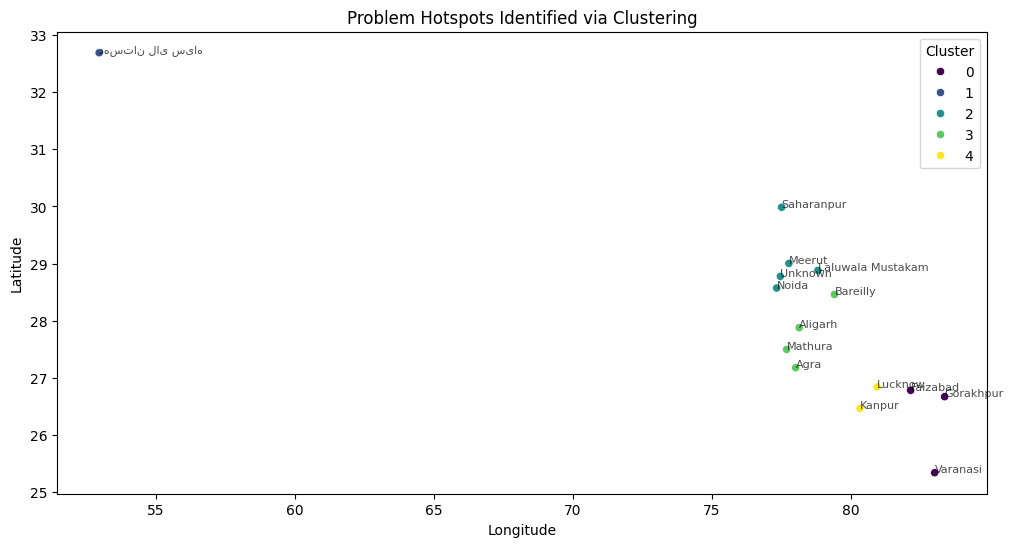

<ipython-input-18-73f0c5a550ac>:56: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Complaint Count", y="Area", data=area_counts.head(10), palette="magma")


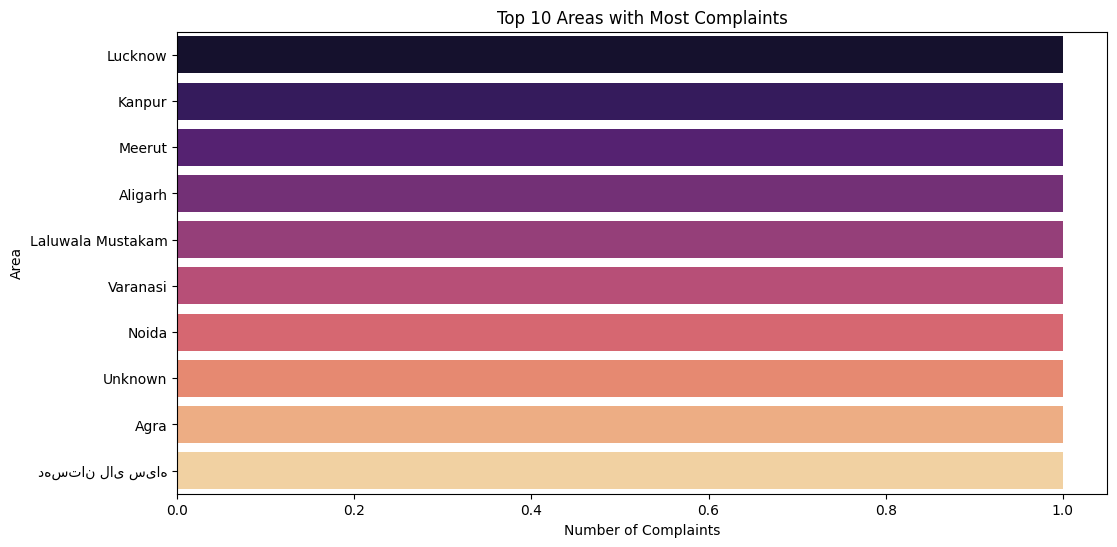

Dropdown(description='Category:', options=('Infrastructure', 'Medical', 'Other', 'Sanitation', 'Utilities'), v…

interactive(children=(Dropdown(description='Category:', options=('Infrastructure', 'Medical', 'Other', 'Sanita…

In [18]:
# Loading CSV File
csv_path = input("Enter the CSV file path: ").strip()
df = pd.read_csv(csv_path)

# Ensuring Date Column Exists(as our CSV File has not Mentioned Date)
if "Date" not in df.columns:
    print("No 'Date' column found. Generating synthetic dates...")
    df["Date"] = pd.date_range(start="2023-01-01", periods=len(df), freq="D")
else:
    df["Date"] = pd.to_datetime(df["Date"])

# Reverse Geocoding to Get Area Names
geolocator = Nominatim(user_agent="myGeocoder")

def get_area(lat, lon):
    """Convert Latitude & Longitude to Area Name"""
    try:
        location = geolocator.reverse((lat, lon), exactly_one=True, timeout=10)
        return location.raw['address'].get('city', location.raw['address'].get('town', location.raw['address'].get('village', 'Unknown')))
    except GeocoderTimedOut:
        time.sleep(1)
        return get_area(lat, lon)
    except Exception as e:
        print(f"Error during reverse geocoding: {e}")
        return "Unknown"

# Appling Reverse Geocoding
valid_locations = df.dropna(subset=["Latitude", "Longitude"]).copy()

# Storing Area Names to Reduce API Calls
area_cache = {}
valid_locations["Area"] = valid_locations.apply(lambda row: area_cache.setdefault((row["Latitude"], row["Longitude"]), get_area(row["Latitude"], row["Longitude"])), axis=1)

# 1 Problem Hotspot Identification using K-Means Clustering
kmeans = KMeans(n_clusters=5, random_state=42, n_init=10)
valid_locations["Cluster"] = kmeans.fit_predict(valid_locations[["Latitude", "Longitude"]])

# 2 Visualizing Problem Hotspots
plt.figure(figsize=(12, 6))
sns.scatterplot(data=valid_locations, x="Longitude", y="Latitude", hue="Cluster", palette="viridis")
plt.title("Problem Hotspots Identified via Clustering")
plt.xlabel("Longitude")
plt.ylabel("Latitude")

# Annotate Clusters with Area Names
for i, row in valid_locations.iterrows():
    plt.text(row["Longitude"], row["Latitude"], row["Area"], fontsize=8, alpha=0.7)

plt.show()

# 3 Aggregating Complaints by Area
area_counts = valid_locations["Area"].value_counts().reset_index()
area_counts.columns = ["Area", "Complaint Count"]

plt.figure(figsize=(12, 6))
sns.barplot(x="Complaint Count", y="Area", data=area_counts.head(10), palette="magma")
plt.title("Top 10 Areas with Most Complaints")
plt.xlabel("Number of Complaints")
plt.ylabel("Area")
plt.show()

# 4 Trend Analysis using ARIMA for All Categories
category_counts = df.groupby(["Date", "Category"]).size().unstack().fillna(0)
categories = category_counts.columns.tolist()

# Dropdown Menu for Category Selection
category_dropdown = widgets.Dropdown(
    options=categories,
    value=categories[0],
    description='Category:',
    disabled=False,
)

def plot_forecast(selected_category):
    ts_data = category_counts[selected_category]
    ts_data.index = pd.to_datetime(ts_data.index)

    ts_data.plot(title=f"Past Trends for {selected_category}")
    plt.show()

    # Fit ARIMA Model
    model = ARIMA(ts_data, order=(2, 1, 2))
    model_fit = model.fit()

    # Predicting Next 30 Days
    forecast = model_fit.forecast(steps=30)
    forecast_dates = [ts_data.index[-1] + pd.Timedelta(days=i) for i in range(1, 31)]

# 5 Plot Future Predictions
    plt.figure(figsize=(10, 5))
    plt.plot(ts_data, label="Historical Data")
    plt.plot(forecast_dates, forecast, label="Predicted Trends", linestyle="dashed")
    plt.legend()
    plt.title(f"Predicted Trend for {selected_category} (Next 30 Days)")
    plt.show()
    print("Predictive analytics complete!")

display(category_dropdown)
widgets.interactive(plot_forecast, selected_category=category_dropdown)